In [1]:
from tqdm import tqdm
import torch
import torchvision
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch import nn
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image

In [2]:
import os
SEED = 42


def set_seed(seed):
    """unchanged from the original code, sets the seed for reproducibility."""

    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)


set_seed(SEED)

In [3]:
def to_cuda(x):
    if torch.cuda.is_available():
        x = x.cuda()
    elif torch.backends.mps.is_available():
        device = torch.device("mps")  # for mac
        x = x.to(device) 
    return x


def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

In [4]:
# Image processing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, ),
                         std=(0.5, ))])
# MNIST dataset
mnist = datasets.MNIST(root='./data/',
                       train=True,
                       transform=transform,
                       download=True)
# Data loader
data_loader = torch.utils.data.DataLoader(dataset=mnist, batch_size=100,  shuffle=True)

# GAN Model

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(0.2),
            nn.Dropout2d(0.3),
            nn.Conv2d(32, 64, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(0.2),
            nn.Dropout2d(0.3),
            nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(0.2),
            nn.Dropout2d(0.3)
        )
        self.fc = nn.Linear(128 * 4 * 4, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.view(-1, 1, 28, 28)  # Reshape input to 2D
        x = self.conv_layers(x)
        x = x.view(-1, 128 * 4 * 4)  # Flatten
        x = self.fc(x)
        x = self.sigmoid(x)
        return x


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc = nn.Linear(64, 128 * 7 * 7)  # Start with a dense layer
        self.conv_layers = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(32, 1, kernel_size=7, stride=1, padding=3),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, 128, 7, 7)  # Reshape into a small "image"
        x = self.conv_layers(x)
        x = x.view(-1, 784)  # Flatten for compatibility with the existing training loop
        return x


# Update your model instantiation
D = Discriminator()
G = Generator()

criterion = nn.BCELoss()

d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0003)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0003)

if torch.cuda.is_available():
    D.cuda()
    G.cuda()
elif torch.backends.mps.is_available():
    D.to(torch.device('mps'))
    G.to(torch.device('mps'))

In [6]:
import numpy as np
from torchvision.utils import make_grid

# Function to display images
def show_images(images, nrow=10, title='Images'):
    grid = make_grid(images, nrow=nrow)
    plt.figure(figsize=(8, 8))
    plt.imshow(np.transpose(grid.cpu().numpy(), (1, 2, 0)), interpolation='nearest')
    plt.title(title)
    plt.axis('off')
    plt.show()

In [7]:
import os

if not os.path.exists('./data/'):
    # If the directory doesn't exist, create it
    os.makedirs('./data/')

## Training:

In [8]:
EPOCHS = 100

discriminator_epoch_loss = []
generator_epoch_loss = []
discriminator_epoch_true_accuracy = []
discriminator_epoch_fake_accuracy = []

for epoch in tqdm(range(EPOCHS + 1), desc='Epochs'):
    temp_discriminator_epoch_loss = 0
    temp_generator_epoch_loss = 0
    temp_true_accuracy = 0
    temp_fake_accuracy = 0

    for i, (images, _) in enumerate(data_loader):

        # Build mini-batch dataset

        batch_size = images.size(0)
        images = to_cuda(images.view(batch_size, -1))
        # Create the labels which are later used as input for the BCE loss
        real_labels = to_cuda(torch.ones(batch_size))
        fake_labels = to_cuda(torch.zeros(batch_size))

        # ============= Train the discriminator =============#
        # Compute BCE_Loss using real images where BCE_Loss(x, y):
        #         - y * log(D(x)) - (1-y) * log(1 - D(x))
        # Second term of the loss is always zero since real_labels == 1

        D.train()
        G.train(False)  # <-> G.eval()
        outputs = D(images)  # Real images

        d_loss_real = criterion(outputs.squeeze(1), real_labels)
        temp_discriminator_epoch_loss += d_loss_real.item()

        real_score = outputs
        temp_true_accuracy += torch.sum(outputs).item()

        # Compute BCELoss using fake images
        # First term of the loss is always zero since fake_labels == 0

        z = to_cuda(torch.randn(batch_size, 64))

        fake_images = G(z)  # Generate fake images

        outputs = D(fake_images)

        d_loss_fake = criterion(outputs.squeeze(1), fake_labels)
        temp_discriminator_epoch_loss += d_loss_fake.item()
        fake_score = outputs
        temp_fake_accuracy += torch.sum(outputs).item()

        # Backprop + Optimize
        d_loss = d_loss_real + d_loss_fake
        D.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        # =============== Train the generator ===============#
        # Compute loss with fake images

        D.train(False)
        G.train()
        z = to_cuda(torch.randn(batch_size, 64))
        fake_images = G(z)
        outputs = D(fake_images)

        # We train G to maximize log(D(G(z)) instead of minimizing log(1-D(G(z)))
        g_loss = criterion(outputs.squeeze(1), real_labels)
        temp_generator_epoch_loss += g_loss.item()

        # Backprop + Optimize
        G.zero_grad()
        g_loss.backward()
        g_optimizer.step()

        # Print out the losses every 300 steps

        # if (i+1) % 300 == 0:
        #     print('Epoch [%d/%d], Step[%d/%d], d_loss: %.4f, '
        #           'g_loss: %.4f, D(x): %.2f, D(G(z)): %.2f'
        #           % (epoch, 200, i+1, 600, d_loss.data, g_loss.data,
        #              real_score.data.mean(), fake_score.data.mean()))

    # update the loss lists
    discriminator_epoch_loss.append(temp_discriminator_epoch_loss / len(data_loader))
    generator_epoch_loss.append(temp_generator_epoch_loss / len(data_loader))
    discriminator_epoch_true_accuracy.append(temp_true_accuracy / len(data_loader.dataset))
    discriminator_epoch_fake_accuracy.append(temp_fake_accuracy / (len(data_loader) * batch_size))

    # show the images 20 times during training
    # if epoch % (EPOCHS // 20) == 0:
    #     fake_images = fake_images.view(-1, 1, 28, 28)  # Ensure correct shape for MNIST
    #     show_images(denorm(fake_images.data), nrow=10, title=f'Epoch {epoch} Fake Images')

    # Save the collage 5 times during training
    if epoch % (EPOCHS // 5) == 0:
        fake_images = fake_images.view(-1, 1, 28, 28)  # Ensure correct shape for MNIST
        save_image(fake_images.data, f'./data/fake_images-{epoch}.png')


# save the model weights
torch.save(D.state_dict(), './data/discriminator.pth')
torch.save(G.state_dict(), './data/generator.pth')

Epochs: 100%|██████████| 101/101 [3:03:30<00:00, 109.02s/it] 


# Discussion:

## Model architecture description:

The GAN model comprises two main components: the Generator (G) and the Discriminator (D). The Generator takes a random noise vector as input and outputs an image that mimics the distribution of the training dataset. It uses a series of transposed convolutional layers to upscale the input noise vector into a full-sized image. The Discriminator, on the other hand, is a convolutional neural network that classifies images as real (from the dataset) or fake (generated by the Generator). Training alternates between optimizing D to better distinguish real images from fake ones and optimizing G to produce images that D is more likely to classify as real.


```plaintext
┌────────────────┐   ┌─────────────┐   ┌────────────────┐   ┌─────────────────────┐
│ Noise Vector z │──►│  Generator  │──►│  Generated     │──►│                     │
└────────────────┘   └─────────────┘   │  Image (Fake)  │   │                     │
                                       └────────────────┘   │                     │
                                                            │  Discriminator (D)  │
                                       ┌────────────────┐   │                     │   ┌────────────┐
                                       │ Real Image     │──►│                     │──►│ Real/Fake  │
                                       └────────────────┘   └─────────────────────┘   └────────────┘


```plaintext
GAN Training Procedure:

Step 1: Train Discriminator on Real Data
+------------------+     +---------------------+     +------------------+
|                  |     |                     |     |                  |
|   Real Image     +---->+   Discriminator(D)  +---->+  Classify as     |
|                  |     |                     |     |  Real            |
+------------------+     +---------------------+     +------------------+
                                                    Discriminator aims to
                                                    maximize the probability
                                                    of correctly classifying
                                                    real data as real.

Step 2: Train Discriminator on Fake Data
+------------------+     +------------------+     +---------------------+     +------------------+
|                  |     |                  |     |                     |     |                  |
|  Noise Vector    +---->+   Generator(G)   +---->+   Discriminator(D)  +---->+  Classify as     |
|                  |     |                  |     |                     |     |  Fake            |
+------------------+     +------------------+     +---------------------+     +------------------+
                                                                    Discriminator aims to
                                                                    maximize the probability
                                                                    of correctly classifying
                                                                    generated data as fake.

Step 3: Train Generator
+------------------+     +------------------+     +---------------------+     +------------------+
|                  |     |                  |     |                     |     |                  |
|  Noise Vector    +---->+   Generator(G)   +---->+   Discriminator(D)  +---->+  Classify as     |
|                  |     |                  |     |                     |     |  Real/Fake       |
+------------------+     +------------------+     +---------------------+     +------------------+
                                                    Generator aims to minimize the probability
                                                    of its generated data being classified as fake
                                                    by the Discriminator.

Repeat Steps 1 to 3 for several epochs until the Generator produces realistic images, and the
Discriminator accurately classifies real and fake images.


## Visualization of the latent space

For visualization of the latent space, we present 2 images generated by the GAN model from random noise vectors. Then we interpolate between these two images by generating images from the latent space points between the two noise vectors. The interpolation is done by linearly interpolating between the two noise vectors and generating images from the interpolated noise vectors. The result is a smooth transition between the two images, showing the continuity of the latent space.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


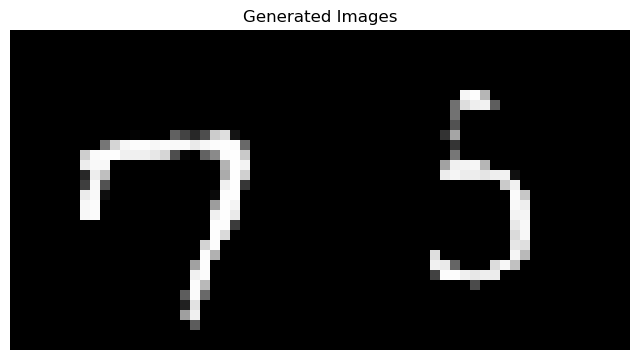

In [9]:
# generate 2 random images
z = to_cuda(torch.randn(2, 64))

fake_images = G(z)
fake_images = fake_images.view(-1, 1, 28, 28)  # Ensure correct shape for MNIST
show_images(fake_images.data, nrow=2, title='Generated Images')

In [10]:
# create 20 vectors of the form w = a z_1 + (1-a) z_2, where z_1 and z_2 are the vectors in z
# and a is a value between 0 and 1
w = []
for a in np.linspace(0, 1, 50):
    w.append(a * z[0] + (1 - a) * z[1])
w = torch.stack(w)

fake_images = G(w)
fake_images = fake_images.view(-1, 1, 28, 28)  # Ensure correct shape for MNIST

C:\Users\gurgu\AppData\Local\Temp\ipykernel_17820\547452950.py:20: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img_pil = to_pil_image(img).resize(new_size, PILImage.ANTIALIAS)
C:\Users\gurgu\AppData\Local\Temp\ipykernel_17820\547452950.py:26: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frames.append(imageio.imread(os.path.join(frames_dir, f'frame_{i:03d}.png')))


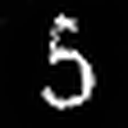

In [11]:
from IPython.display import Image as IPythonImage
import imageio
import os
import PIL.Image as PILImage
import torchvision.transforms as transforms

# Assuming fake_images is already generated as shown in your code snippet
to_pil_image = transforms.ToPILImage()

# Desired size (width, height)
new_size = (128, 128)

# Create a directory for frames if it doesn't already exist
frames_dir = './frames'
os.makedirs(frames_dir, exist_ok=True)

# Save each fake image as a frame, resized to new_size
for i, img in enumerate(fake_images):
    img_path = os.path.join(frames_dir, f'frame_{i:03d}.png')
    img_pil = to_pil_image(img).resize(new_size, PILImage.ANTIALIAS)
    img_pil.save(img_path)

# Compile frames into a gif
frames = []
for i in range(len(fake_images)):
    frames.append(imageio.imread(os.path.join(frames_dir, f'frame_{i:03d}.png')))

gif_path = './generated_images_large.gif'
imageio.mimsave(gif_path, frames, fps=5)  # Adjust fps as needed

# Optionally, display the GIF in Jupyter Notebook
IPythonImage(filename=gif_path)


## Convergence plots - discriminator and generator losses:

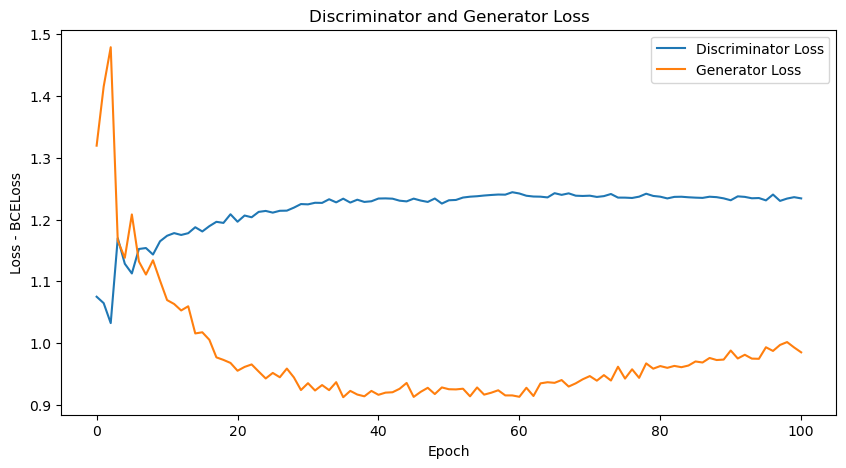

In [12]:
import matplotlib.pyplot as plt

# plot the losses of the discriminator and generator over the epochs
plt.figure(figsize=(10, 5))
plt.plot(discriminator_epoch_loss, label='Discriminator Loss')
plt.plot(generator_epoch_loss, label='Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss - BCELoss')
plt.legend()
plt.title('Discriminator and Generator Loss')
plt.show()

#### Analysis of the graph
The convergence plots for the Discriminator and Generator losses offer insight into the adversarial training dynamics. Initially, both losses may fluctuate as G and D are learning. Over time, the Discriminator loss stabilizes as it becomes proficient in distinguishing real from fake images. Meanwhile, the Generator's loss decreases as it becomes better at creating images that fool the Discriminator. Ideally, both losses will converge to a point indicating a balance has been reached; however, perfect equilibrium is challenging due to the adversarial nature of the training.

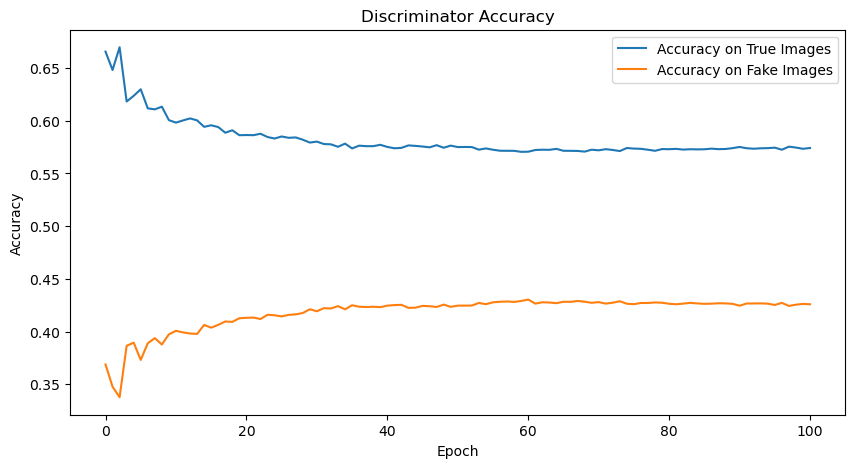

In [13]:
# plot the accuracy of the discriminator over the epochs
plt.figure(figsize=(10, 5))
plt.plot(discriminator_epoch_true_accuracy, label='Accuracy on True Images')
plt.plot(discriminator_epoch_fake_accuracy, label='Accuracy on Fake Images')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Discriminator Accuracy')
plt.show()

#### Analysis of the graph
The Discriminator's accuracy graph provides critical insights into the GAN's training dynamics. Ideally, we aim for the Discriminator to have a 50% accuracy rate on both real and fake images, indicating that it is equally likely to classify real and generated images correctly. This balance suggests that the Generator is producing images indistinguishable from real images, fulfilling the primary goal of a GAN.

## Summary of our attempts and conclusions:

Through iterative experimentation with our GAN model, we adjusted hyperparameters, experimented with different architectures, and applied techniques like batch normalization to improve training stability. We observed the critical role of the balance between the Generator and Discriminator in achieving realistic image generation. Overfitting and mode collapse were significant challenges that necessitated careful monitoring and adjustment of the training process.

## Visual results of the trained model:

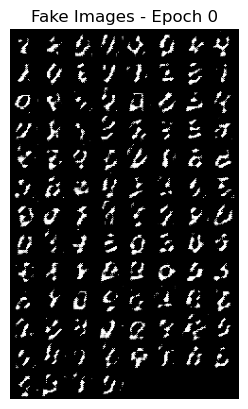

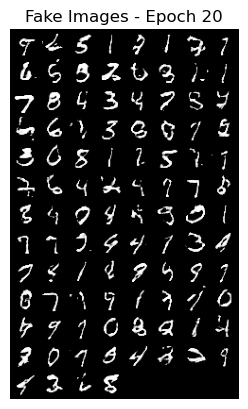

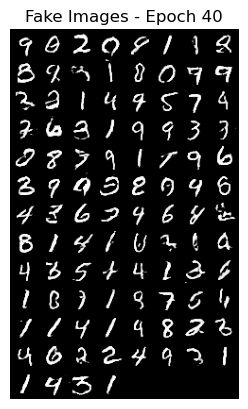

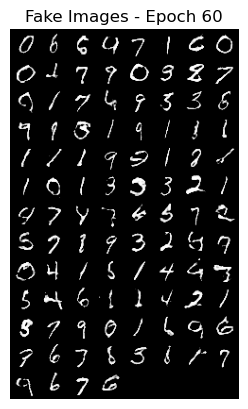

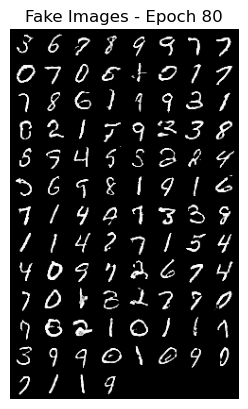

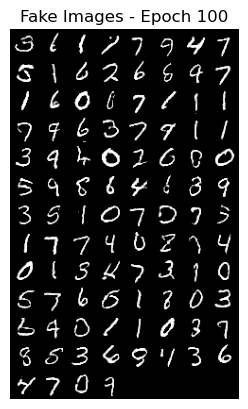

In [14]:
import matplotlib.pyplot as plt
from PIL import Image

# show all of the collages of the fake images
for collage_num in range(0, EPOCHS + 1, EPOCHS // 5):
    # Load the image
    img_path = './data/fake_images-' + str(collage_num) + '.png'
    img = Image.open(img_path)

    # Display the image
    plt.imshow(img)
    plt.title('Fake Images - Epoch ' + str(collage_num))
    plt.axis('off')  # Turn off axis numbers and ticks
    plt.show()

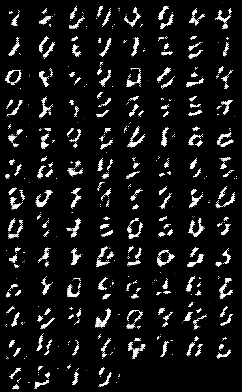

In [15]:
from IPython.display import Image as IPythonImage
from PIL import Image
import glob

# Collecting the images
images = []
for img_path in sorted(glob.glob('./data/fake_images-*.png')):
    images.append(Image.open(img_path))

# Ensure there are images to convert
if images:
    # Save the images as a GIF
    gif_path = './data/collage.gif'
    images[0].save(gif_path, save_all=True, append_images=images[1:], optimize=False, duration=1000, loop=0)

    # Display the GIF
    display(IPythonImage(filename=gif_path))
else:
    print("No images found to create a GIF.")

# Code for results reproduction

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


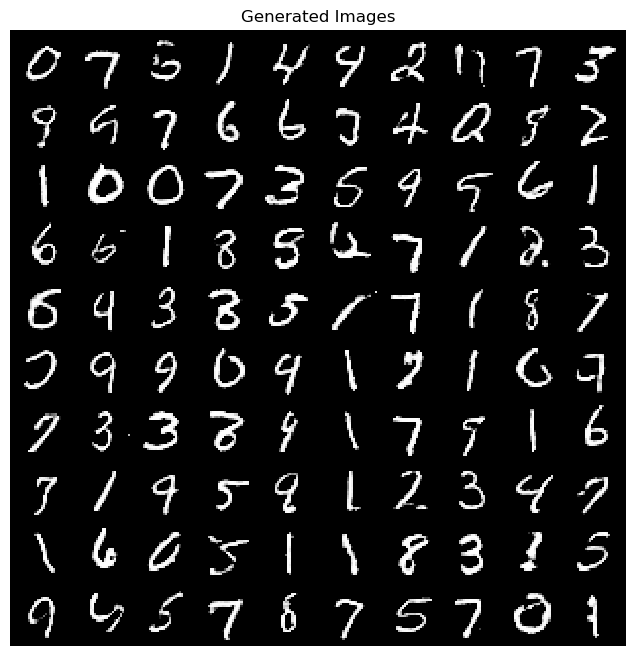

In [16]:
def reproduce_hw3(discriminator_pth, generator_pth):
    class Discriminator(nn.Module):
        def __init__(self):
            super(Discriminator, self).__init__()
            self.conv_layers = nn.Sequential(
                nn.Conv2d(1, 32, kernel_size=5, stride=2, padding=2),
                nn.LeakyReLU(0.2),
                nn.Dropout2d(0.3),
                nn.Conv2d(32, 64, kernel_size=5, stride=2, padding=2),
                nn.LeakyReLU(0.2),
                nn.Dropout2d(0.3),
                nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2),
                nn.LeakyReLU(0.2),
                nn.Dropout2d(0.3)
            )
            self.fc = nn.Linear(128 * 4 * 4, 1)
            self.sigmoid = nn.Sigmoid()

        def forward(self, x):
            x = x.view(-1, 1, 28, 28)  # Reshape input to 2D
            x = self.conv_layers(x)
            x = x.view(-1, 128 * 4 * 4)  # Flatten
            x = self.fc(x)
            x = self.sigmoid(x)
            return x

    class Generator(nn.Module):
        def __init__(self):
            super(Generator, self).__init__()
            self.fc = nn.Linear(64, 128 * 7 * 7)  # Start with a dense layer
            self.conv_layers = nn.Sequential(
                nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
                nn.LeakyReLU(0.2),
                nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
                nn.LeakyReLU(0.2),
                nn.ConvTranspose2d(32, 1, kernel_size=7, stride=1, padding=3),
                nn.Tanh()
            )

        def forward(self, x):
            x = self.fc(x)
            x = x.view(-1, 128, 7, 7)  # Reshape into a small "image"
            x = self.conv_layers(x)
            x = x.view(-1, 784)  # Flatten for compatibility with the existing training loop
            return x

    # read the model weights
    D = Discriminator()
    G = Generator()

    D.load_state_dict(torch.load(discriminator_pth))
    G.load_state_dict(torch.load(generator_pth))

    # generate some fake images
    G.eval()
    z = to_cuda(torch.randn(100, 64))
    fake_images = G(z)
    fake_images = fake_images.view(-1, 1, 28, 28)  # Ensure correct shape for MNIST
    show_images(fake_images.data, nrow=10, title='Generated Images')


# reproduce the results from HW3
reproduce_hw3('./data/discriminator.pth', './data/generator.pth')